In [3]:
""" Copyright 2023, Rayan Bahrami, 
    Safe Autonomous Systems Lab (SAS Lab)
    Stevens Institute of Technology
    See LICENSE file for the license information.
"""

import numpy as np
import math
from scipy.io import loadmat, savemat
from scipy import linalg
from copy import deepcopy

from omegaconf import OmegaConf

import os
import sys

parent_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(parent_dir)

from core.utils import (
    Adj_to_Lap,
    Lap_to_Adj,
    DPMSR_update_neighbors,
    get_DoS,
)

import matplotlib as mpl
import matplotlib.pyplot as plt

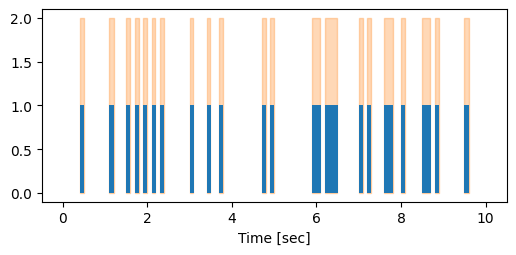

In [6]:
cfg = OmegaConf.load("../configs/exp1.yaml")
DoS = get_DoS(p=cfg.DoS.p, num_dos=cfg.DoS.n, t_s=cfg.Ts, t_end=cfg.T_end, seed=80658)

In [12]:
# cfg = OmegaConf.load("../configs/exp1.yaml")
Adj = np.array(cfg.Adj_overlay)

ORIGINAL_PARAMS = False

if ORIGINAL_PARAMS:
    # a fixed lower bound on communication links encoded in the adjacency matrix:
    gamma = 1 / Adj.sum(axis=1).max()
    # the paper does not report the gamma value
    # Yet, alpha = 1/d, where d is the maximum in-degree of agents meet the
    # conditions specided in Section 2.1 of the Dibaji's paper paper.
    alpha = cfg.gamma
    Ts = 0.5
    duration = 40
else:
    # check out the footnoe attached to Equation (9) in the Dibaji's paper (Elsevier 2017).
    # use the parameter as in ./configs/
    gamma = cfg.alpha  # note gamma & alpha are different here !
    alpha = cfg.gamma
    Ts = cfg.Ts
    duration = cfg.T_end

if ORIGINAL_PARAMS and any(np.sum(Adj * gamma, axis=1) > 1):
    print(
        "Warning! decrease the value of gamma! and check Section 2.1 of the Dibaji paper"
    )
    # Condition on sample-time Ts and parameter alpha:
    if not (1 + Ts ^ 2 / 2 <= alpha * Ts and alpha * Ts <= 2 - Ts ^ 2 / 2):
        print(
            "Error: sample-time, Ts, and control gain, alpha, do not meet the condition (9) of the Dibaji paper"
        )


Adj = Adj * gamma
N = len(Adj)

px0 = np.array(cfg.IC.px)
vx0 = np.array(cfg.IC.vx)

adversaries_ID = [4]  # cfg.Adversaries.ID


# ==== initilization =======
B_ua = np.zeros(2 * N)
adv = np.eye(N)
adv[adversaries_ID, adversaries_ID] = 0
coop_agents = np.setdiff1d(np.arange(N), adversaries_ID)
# B_ua[adversaries_ID[0]] = lambda t: 0.3 * t
# B_ua[adversaries_ID[1]] = lambda t: 0.5 * t

agents_detections = {}
P, V, Ua = [], [], np.zeros(N)
Z1, Z2 = [], []
P += [px0]
V += [vx0]
Z1 += [px0]
Z2 += [vx0]

# ==== main loop =======
k = 0
while (k * Ts) < duration:
    t = k * Ts

    adj_cur = DPMSR_update_neighbors(
        x=P[-1], F=1, Adj=Adj, malicious_agents=[4], threshold=0
    )

    # update control
    Lap = Adj_to_Lap(adj_cur) * (1 - DoS[k])

    Ua[adversaries_ID[0]] = 0.3 * t
    # Ua[adversaries_ID[1]] = 0.5 * t
    U = -(adv @ Lap).dot(P[-1]) - alpha * (adv @ np.eye(N)).dot(V[-1]) + Ua

    # Zero-order hold discretization
    P += [P[-1] + Ts * V[-1] + (Ts**2) / 2 * U]
    V += [V[-1] + Ts * U]

    k += 1  # time increment


P = np.array(P)
V = np.array(V)

Text(0.5, 0, 'Time [sec]')

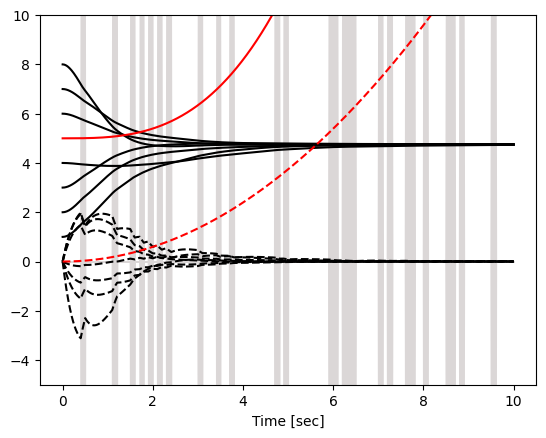

In [13]:
if ORIGINAL_PARAMS:
    T = np.linspace(0, duration, np.int64(duration / Ts) + 1)
else:
    T = np.linspace(0, cfg.T_end, np.int64(cfg.T_end / cfg.Ts) + 1)
    plt.fill_between(T, 10 * DoS, color="#dbd7d7")
    plt.fill_between(T, -10 * DoS, color="#dbd7d7")

plt.plot(T, P[:, coop_agents], "k")
plt.plot(T, V[:, coop_agents], "--k")
plt.plot(T, P[:, adversaries_ID], "r")
plt.plot(T, V[:, adversaries_ID], "--r")
plt.ylim([-5, 10])
plt.xlabel(r"Time [sec]")